# Variational autoencoders
Some useful links.

Good theoretical introduction:
https://arxiv.org/pdf/1606.05908.pdf

High-level description:
http://kvfrans.com/variational-autoencoders-explained/

Tensorflow example:
https://jmetzen.github.io/2015-11-27/vae.html

Another tensorflow walkthrough:  
http://blog.fastforwardlabs.com/2016/08/12/introducing-variational-autoencoders-in-prose-and.html  
http://blog.fastforwardlabs.com/2016/08/22/under-the-hood-of-the-variational-autoencoder-in.html


Keras example:

https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder.py

This notebook is heavily influenced by the keras example.

In [22]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import keras
import matplotlib.pyplot as plt
import numpy as np

from keras import backend as K
from keras.layers import Dense, Dropout, Input, Lambda, Layer
from keras.models import Model
from scipy.stats import norm

In [23]:
class VariationalLayer(Layer):
    ''' Create Variational auto-encoder. It should be called with all of:
            
            training values
            final output (after going through encoder and decoder)
            mean of latent variables
            log variance of latent variables
        
        It manually adds a loss term to the model; therefore the model should subsequently
        be compiled with loss=None.
    '''
    
    def _vae_loss(self, x, x_decoded_mean, z_mean, z_log_var):
        ''' Compute the variational loss -- this is the sum of a model-specific term, and a KL
            divergence term that is independent of any modelling choice.
        '''
        model_loss = self.model_nll(x, x_decoded_mean)
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(model_loss + kl_loss)
    
    def model_nll(self, x, x_pred):
        ''' The negative log likelihood of x given a prediction x_pred.
            Default implementation uses binary cross-entropy.
        '''
        # Summing over the last axis, which corresponds to the features on each training sample.
        # GARGH - Keras has recently changed the order of the arguments to binary_crossentropy.
        # Work around by explicitly specifying them as keyword arguments
        return K.sum(K.binary_crossentropy(output=x_pred, target=x), axis=-1)
        
    def call(self, inputs):
        x, x_decoded_mean, z_mean, z_log_var = inputs
        loss = self._vae_loss(x, x_decoded_mean, z_mean, z_log_var)
        self.add_loss(loss, inputs=inputs)
        # TODO this isn't used - to what extent does it matter what we return?
        return loss
    

def make_vae(dim_original, n_layers=1, dim_latent=2, dim_intermediate=256, 
             cls_vae=VariationalLayer, activation='relu', decoder_activation='sigmoid', 
             optimizer='adam', dropout=0.2):
    ''' Construct a Variational Autoencoder.
    
        If dropout is None, then don't apply any dropout layers.
    
        Returns (untrained) models for vae, encoder, and decoder.
    '''
    x = Input(shape=(dim_original,))
    
    h = x
    for _ in range(n_layers):
        h = Dense(dim_intermediate, activation=activation)(h)
        if dropout is not None:
            h = Dropout(dropout)(h)
        
    # Means and log of the variance for each of the latent variables
    z_mean = Dense(dim_latent)(h)
    z_log_var = Dense(dim_latent)(h)
    
    def sample(args):
        ''' Given (mean, log_var), return samples from N(mean, std) '''
        z_mean, z_log_var = args
        # Construct appropriate number of samples from N(0, 1), depending on the runtime shape of z_mean
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], dim_latent), mean=0, stddev=1)
        # Rescale by mean & variance
        return z_mean + K.exp(z_log_var / 2) * epsilon
    
    # This is a layer which generates samples from z, given appropriate parameter tensors
    z = Lambda(sample, output_shape=(dim_latent,))([z_mean, z_log_var])
    
    # We use these layers in the forward-propagating sense layer. Save them to allow weight re-use.
    decoder_hs = []
    for _ in range(n_layers):
        decoder_hs.append(Dense(dim_intermediate, activation=activation))
        if dropout is not None:
            decoder_hs.append(Dropout(dropout))
    decoder_mean = Dense(dim_original, activation=decoder_activation)
    
    def decoder_h(z):
        ''' Apply all elements in decoder_hs '''
        for decoder_layer in decoder_hs:
            z = decoder_layer(z)
        return z
    
    # Instantiate the layers for the vae model - decode the latent variable we've generated into the target space.
    h_decoded = decoder_h(z)
    x_decoded_mean = decoder_mean(h_decoded)
    
    y = cls_vae()([x, x_decoded_mean, z_mean, z_log_var])
    
    vae = Model(x, y)
    # TODO Presumably we set loss as 'None' here because we called 'add_loss' in VariationalLayer?
    vae.compile(optimizer=optimizer, loss=None)
    
    # Model which will give the mean of the latent parameter that we are using from points in the input space.
    encoder = Model(x, z_mean)
    
    decoder_input = Input(shape=(dim_latent,))
    _h_decoded = decoder_h(decoder_input)
    _x_decoded_mean = decoder_mean(_h_decoded)
    decoder = Model(decoder_input, _x_decoded_mean)
    
    return vae, encoder, decoder

Load the mnist dataset

In [24]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(60000, 784) (60000,)
(10000, 784) (10000,)


Train the VAE on mnist...

In [25]:
vae, encoder, decoder = make_vae(x_train.shape[1])

batch_size = 100

history = vae.fit(
    x_train,
    shuffle=True,
    epochs=50,
    batch_size=batch_size,
    validation_data=(x_test, None))

/Users/thomas/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:92: UserWarning: Output "variational_layer_3" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "variational_layer_3" during training.


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 7s - loss: 200.5109 - val_loss: 173.6796
Epoch 2/50
60000/60000 [==============================] - 6s - loss: 173.1127 - val_loss: 169.3986
Epoch 3/50
60000/60000 [==============================] - 6s - loss: 170.3246 - val_loss: 167.3116
Epoch 4/50
60000/60000 [==============================] - 5s - loss: 168.6697 - val_loss: 165.7925
Epoch 5/50
60000/60000 [==============================] - 6s - loss: 167.4628 - val_loss: 164.6621
Epoch 6/50
60000/60000 [==============================] - 5s - loss: 166.5317 - val_loss: 163.6044
Epoch 7/50
60000/60000 [==============================] - 6s - loss: 165.8041 - val_loss: 162.8179
Epoch 8/50
60000/60000 [==============================] - 6s - loss: 165.1067 - val_loss: 162.0287
Epoch 9/50
60000/60000 [==============================] - 6s - loss: 164.6463 - val_loss: 161.4387
Epoch 10/50
60000/60000 [==============================] - 

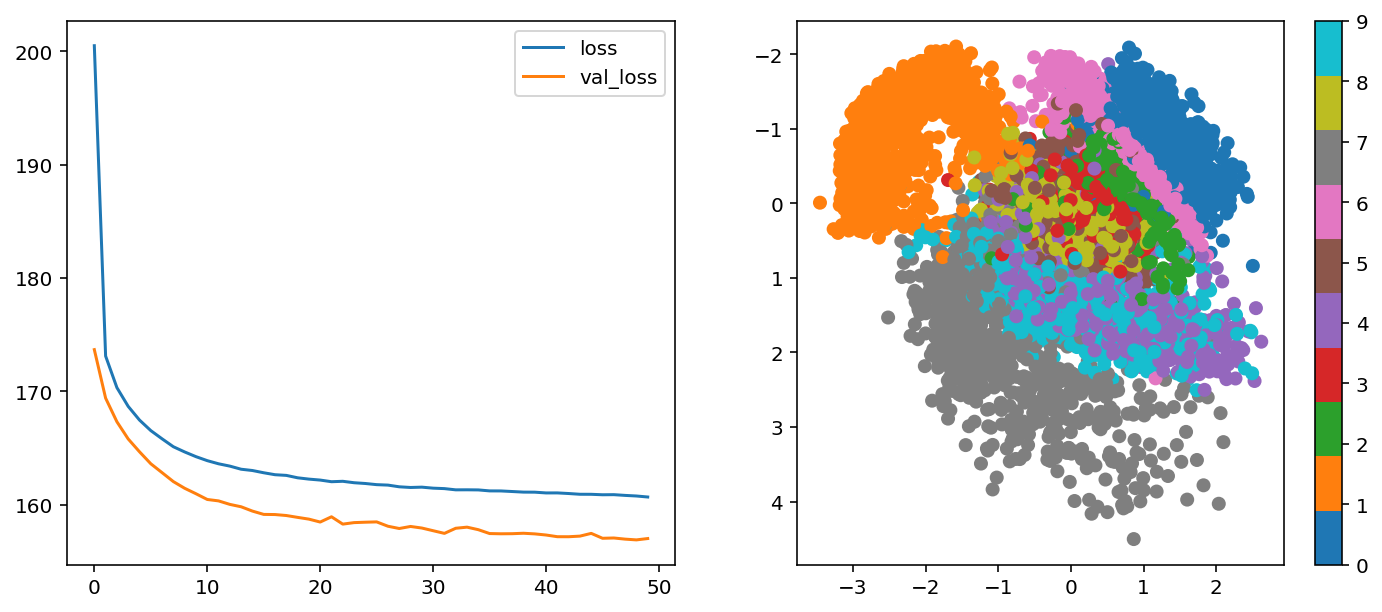

In [26]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.epoch, history.history['loss'], label='loss')
plt.plot(history.epoch, history.history['val_loss'], label='val_loss')
plt.legend()

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.subplot(1, 2, 2)
# 'tab10' colour map has 10 discrete elements, which is useful for this case.
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap='tab10')

# Reverse the y-axis, so there is better correspondence with the image below
plt.ylim(plt.ylim()[::-1])
plt.colorbar();

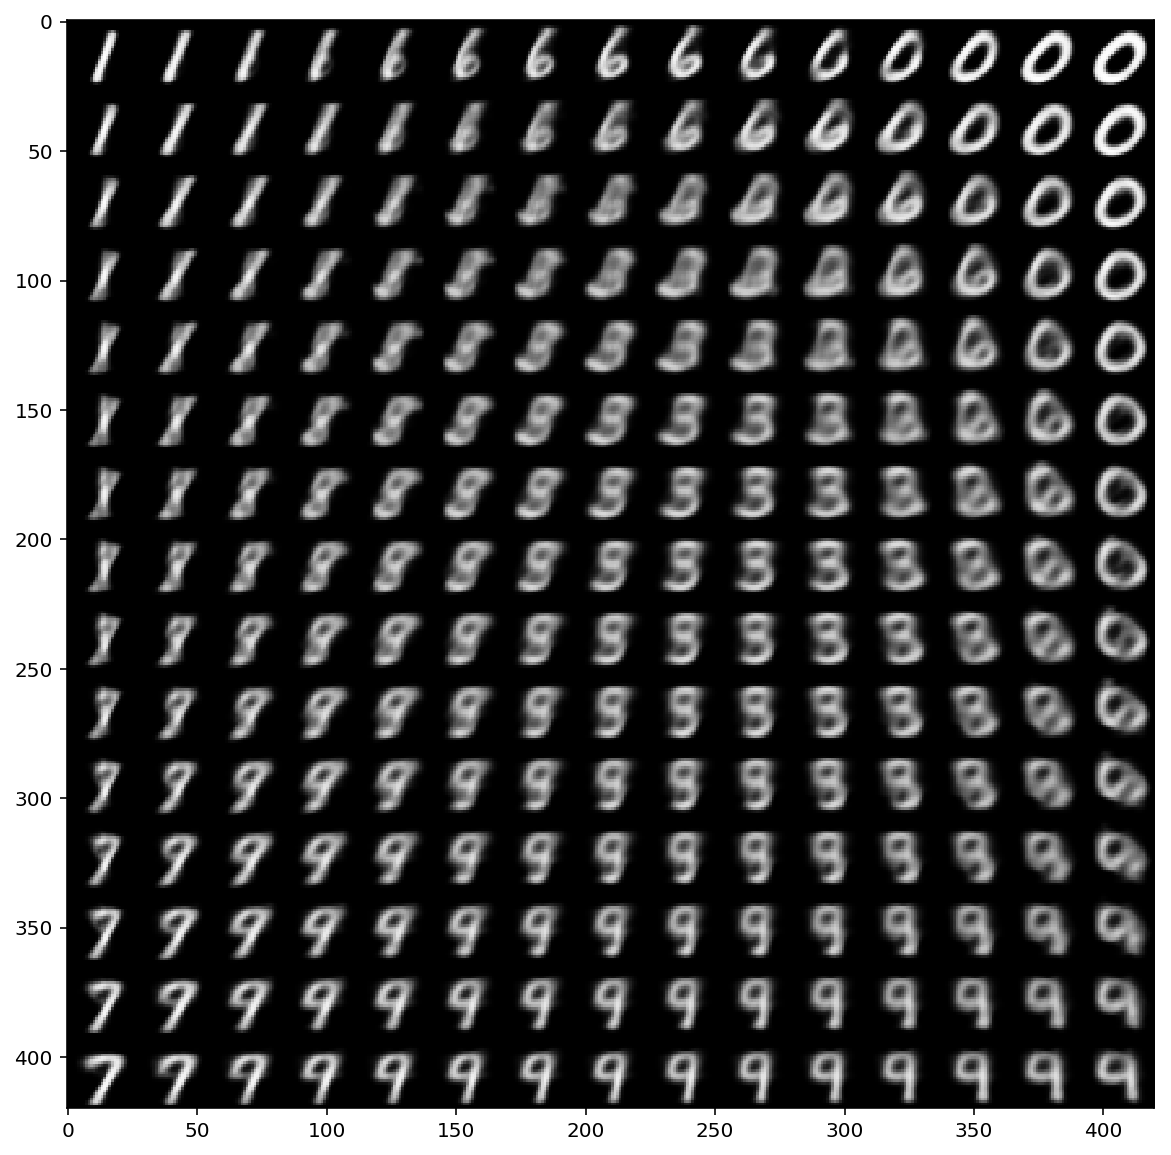

In [27]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit


plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r');

# Application to manifold example

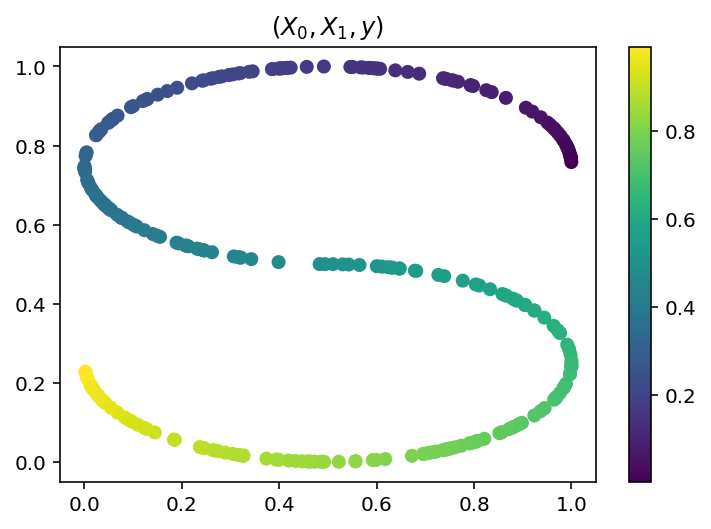

In [28]:
def embed_features(x):
    ''' Given an input vector, apply a transformation to embed it in a higher dimensional space. '''
    assert len(x.shape) == 1, 'Unsupported shape {}'.format(x.shape)

    # TODO add noise, optionally?
    new_X = np.zeros((x.shape[0], 2))

    # This is the true embedding transformation - it creates an S shape in (0, 1) box
    t = 3 * np.pi * (x - 0.5)
    new_X[:, 0] = (1 + np.sin(t)) / 2
    new_X[:, 1] = (np.sign(t) * (np.cos(t) - 1) + 2) / 4

    return new_X

num_samples = 300
x = np.random.random(num_samples)

X = embed_features(x)

plt.title('$(X_0, X_1, y)$')
plt.scatter(X[:, 0], X[:, 1], c=x);
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.colorbar();

In [29]:
vae, encoder, decoder = make_vae(X.shape[1], dim_latent=1, n_layers=1, dim_intermediate=100)

def _fit_model(vae, verbose=0, epochs=500, batch_size=32):
     return vae.fit(X, shuffle=True, epochs=epochs, verbose=verbose, validation_data=(X, None), 
                    batch_size=batch_size)

history = _fit_model(vae)

/Users/thomas/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:92: UserWarning: Output "variational_layer_4" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "variational_layer_4" during training.


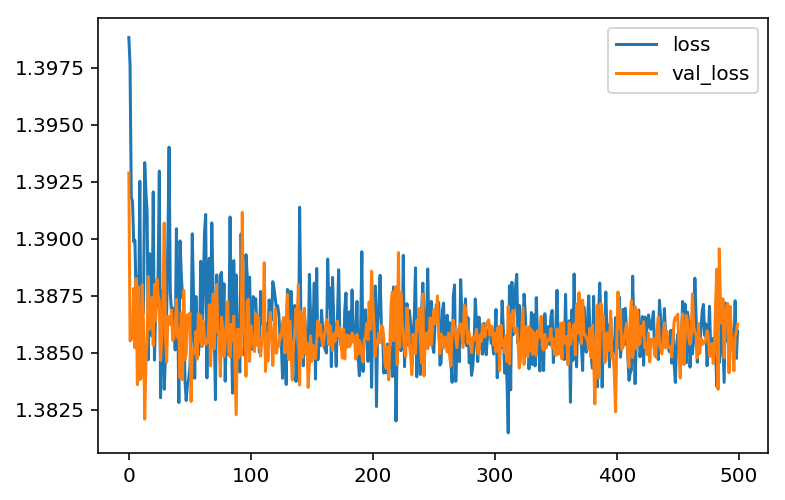

In [30]:
plt.plot(history.epoch, history.history['loss'], label='loss')
plt.plot(history.epoch, history.history['val_loss'], label='val_loss')
plt.legend();

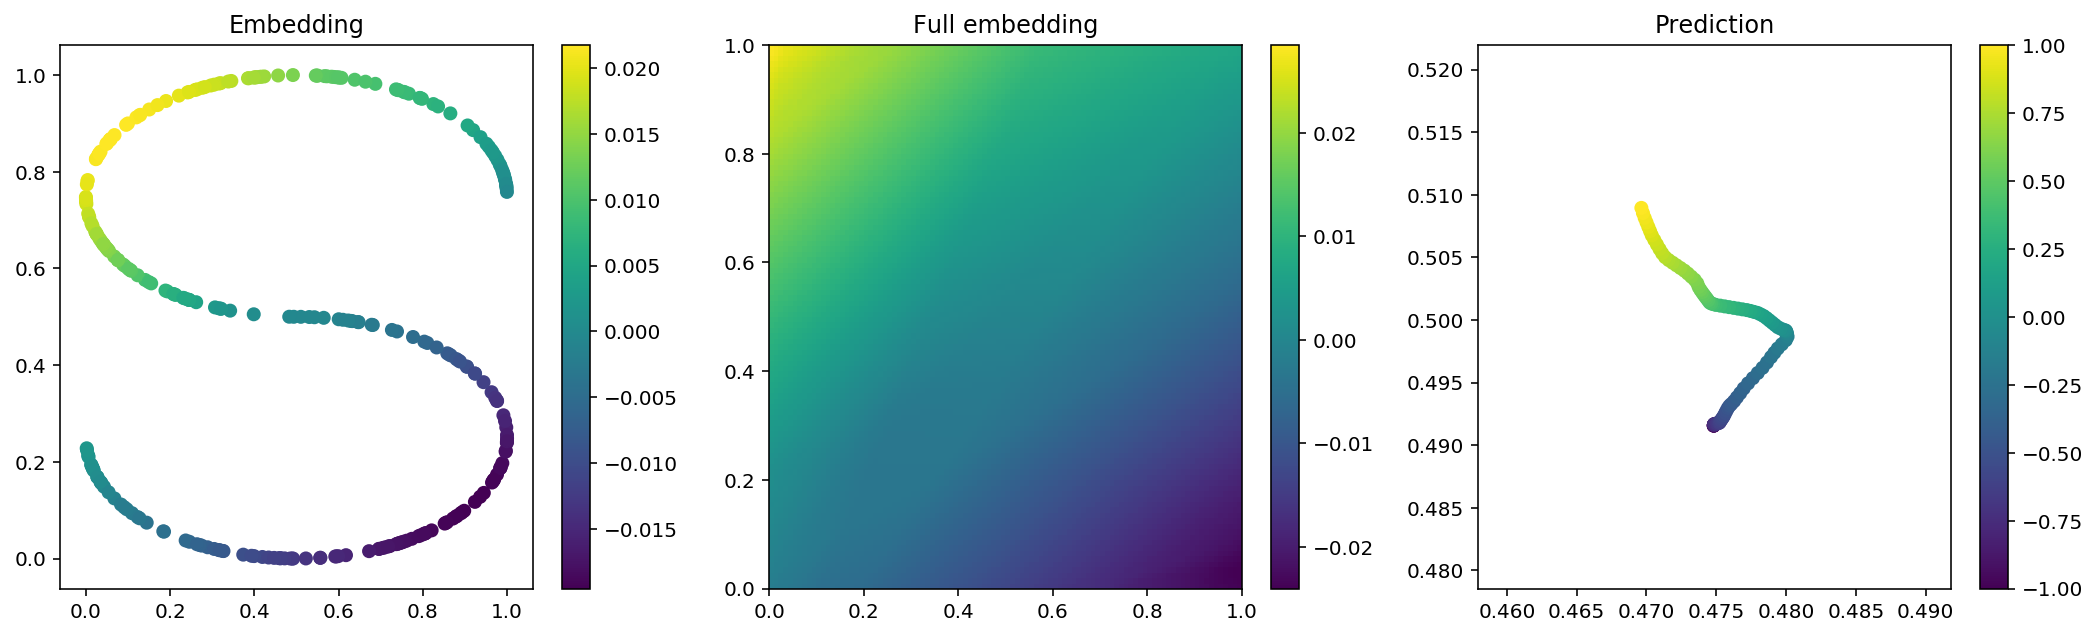

In [31]:
def _plot_decoded_points(decoder_predict, num_grid_points=100):
    ''' Creating a 1D mesh of points in the encoded variable space, see how it maps back into real space '''
    t = np.linspace(-1, 1, num_grid_points)
    X = decoder_predict(t)
    plt.scatter(X[:, 0], X[:, 1], c=t)
    plt.colorbar()
#     plt.xlim(-0.05, 1.05)
#     plt.ylim(-0.05, 1.05)

def _make_grid(num_grid_points):
    ''' Make a 2D grid with the given number of points in each dimension '''
    x = np.linspace(0, 1, num_grid_points)
    X0, X1 = np.meshgrid(x, x)
    return np.stack((X0.flatten(), X1.flatten()), axis=1)


def _plot_full_embedding(predictor, num_grid_points=100):
    ''' Given a mapping from X -> t, plot the full embedding '''
    X_full = _make_grid(num_grid_points)
    t_full = predictor(X_full)
    # The imshow command is roughly equivalent to the commented-out scatter call, however should look
    # better, and be much faster.
    # plt.scatter(X_full[:, 0], X_full[:, 1], c=t_full)
    plt.imshow(t_full.reshape((num_grid_points, num_grid_points)), 
               origin='lower', 
               extent=[0, 1, 0, 1], 
               aspect='auto')
    plt.colorbar();
    
def plot_encoder_decoder(encoder, decoder):
    plt.figure(figsize=(18, 5))
    plt.subplot(1, 3, 1)
    plt.title('Embedding')
    plt.scatter(X[:, 0], X[:, 1], c=encoder.predict(X))
    plt.colorbar();

    plt.subplot(1, 3, 2)
    plt.title('Full embedding')
    _plot_full_embedding(encoder.predict)
    
    plt.subplot(1, 3, 3)
    plt.title('Prediction')
    _plot_decoded_points(decoder.predict)

# The encoder is mapping from the input space to the *mean* of the latent variable distribution, E_z[Q(z|x)]
plot_encoder_decoder(encoder, decoder)

What on earth is going on? Broadly speaking, performance is terrible. What we know:

* The range of z_mean is only in roughly [-0.005, 0.005].
* When applying the decoder to z in that range, or even [-1, 1], the space in x obtained is very small.
* Predictive distribution P(x|z) seems tightly centred on (0.5, 0.5)

Hypothesis -- gradient descent is failing to discover the true distribution. In some sense it's trying to approximate the "average" case(?)

## Aha!!

The problem is that we are comparing the 'goodness' of the prediction $x'$ of $x$ using binary cross-entropy,

$$H(x, x') =-\sum_i\left(x_i\log(x'_i) + (1 - x_i)\log(1 - x'_i)\right).$$

The subscript $i$ in this expression corresponds to the vector index of a particular sample. For images like the MNIST digits above, this makes sense since we're parameterising our distribution on the domain of images as a set of probabilities that each pixel is 0 or 1. 

\begin{align}
H(x, x') &= - \log\mathcal{L}(x, x') \\
\mathcal{L}(x, x') &= \exp\left( \sum_i\left(x_i\log(x'_i) + (1 - x_i)\log(1 - x'_i)\right)  \right) \\
 &= \prod_i \exp \left(x_i\log(x'_i) + (1 - x_i)\log(1 - x'_i)\right) \\
 &= \prod_i \exp \left( x_i\log(x'_i) \right) \cdot \exp \left( (1 - x_i)\log(1 - x'_i) \right) \\
 &= \prod_i {x'_i}^{x_i} {(1 - x'_i)}^{1 - x_i}.
\end{align}

If one assumes that $0\le x_i \le 1$, $0\le x'_i \le 1,\  \forall i$, up to constant terms this looks vaguely like a product over $N$ binomial distributions, with the exception that the powers aren't integers. Which isn't much good... however in fact this is of the form of a product of beta distributions:

$$ \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)} x^{\alpha - 1} (1 - x)^{\beta - 1}, $$

in the case that

$$ x = x_i,\qquad \alpha = 1 + x'_i,\qquad \beta = 2 - x'_i. $$

Refer e.g. to wikipedia (https://en.wikipedia.org/wiki/Beta_distribution). Let's plot a few values in the case in which we're interested.

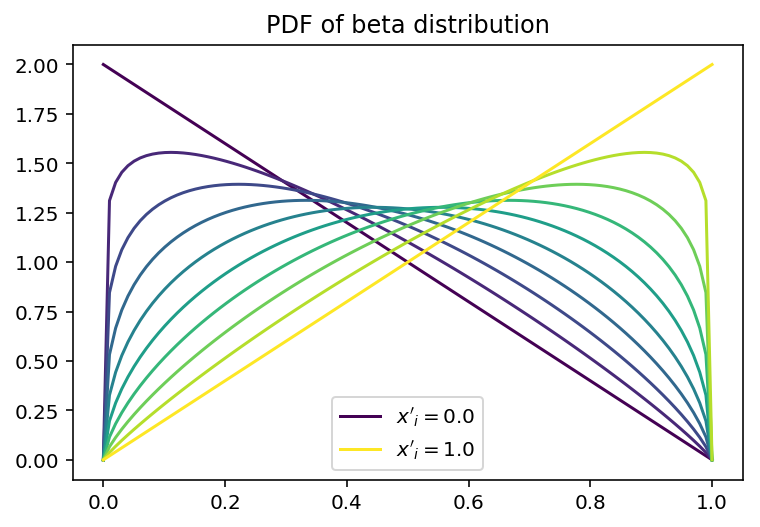

In [32]:
from scipy.stats import beta

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

mappable = ScalarMappable(norm=Normalize(0, 1), cmap='viridis')

x = np.linspace(0, 1, 100)
for i, xi in enumerate(np.linspace(0, 1, 10)):
    # Only show the label for the first and last lines
    show_label = xi == 0 or xi == 1

    a = 1 + xi
    b = 2 - xi
    y = beta.pdf(x, a, b)
    color = mappable.to_rgba(xi)
    if show_label:
        label = "$x'_i = {}$".format(xi)
        plt.plot(x, y, color=color, label=label)
    else:
        plt.plot(x, y, color=color)
    
plt.title('PDF of beta distribution')
plt.legend();

In other words, this represents a probability distribution which prefers larger $x_i$ given large $x'_i$, and vice versa. This makes vaguely intuitive sense for the example at hand; in the context of MNIST it roughly means that pixels should have a similar value to their "true" value, and also that pixels are all independent.

Note that we appear to be sweeping the "constant" factor -- that is a function of $x'_i$ -- under the carpet when doing this computation. Is this justifiable? Not sure.

## Proceeding with different model loss

Given this interpretation, we are free to chose whatever means we like of defining $\mathcal{L}(x, x')$. In our case we simple want the values to be close in a Euclidean sense, so a gaussian makes sense. This lends itself to a mean-squared loss function.

Below we tweak the VAE implementation (some of the customisation has been refactored into the functions above to provide somewhat improved code re-use...)

In [33]:
from keras.optimizers import Adam

class MSEVariationalLayer(VariationalLayer):
    ''' Similar to VariationalLayer, but with a Gaussian model '''
    
    def model_nll(self, x, x_pred):
        ''' The negative log likelihood of x given a prediction x_pred. '''
        # Summing over the last axis, which corresponds to the features on each training sample.
        return K.sum(K.square(x_pred - x), axis=-1)
    
vae, encoder, decoder = make_vae(X.shape[1], dim_latent=1, n_layers=5, dim_intermediate=40, 
                                 cls_vae=MSEVariationalLayer, decoder_activation='tanh',
                                optimizer=Adam(lr=0.0001))
history = _fit_model(vae, epochs=500, verbose=0, batch_size=200)

/Users/thomas/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:92: UserWarning: Output "mse_variational_layer_6" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "mse_variational_layer_6" during training.


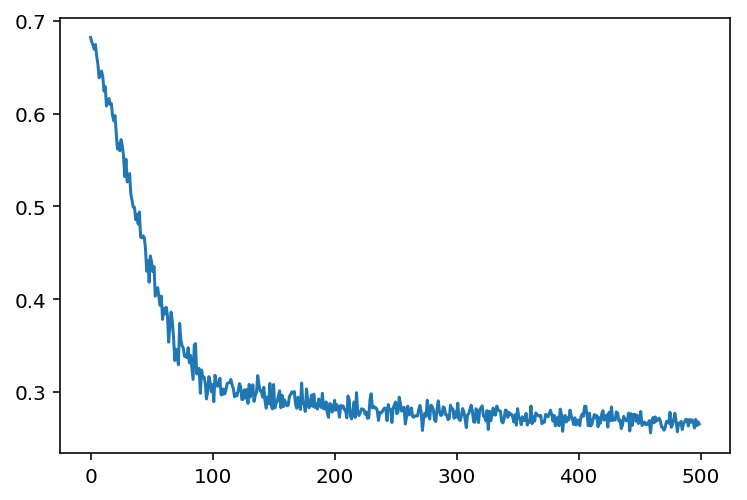

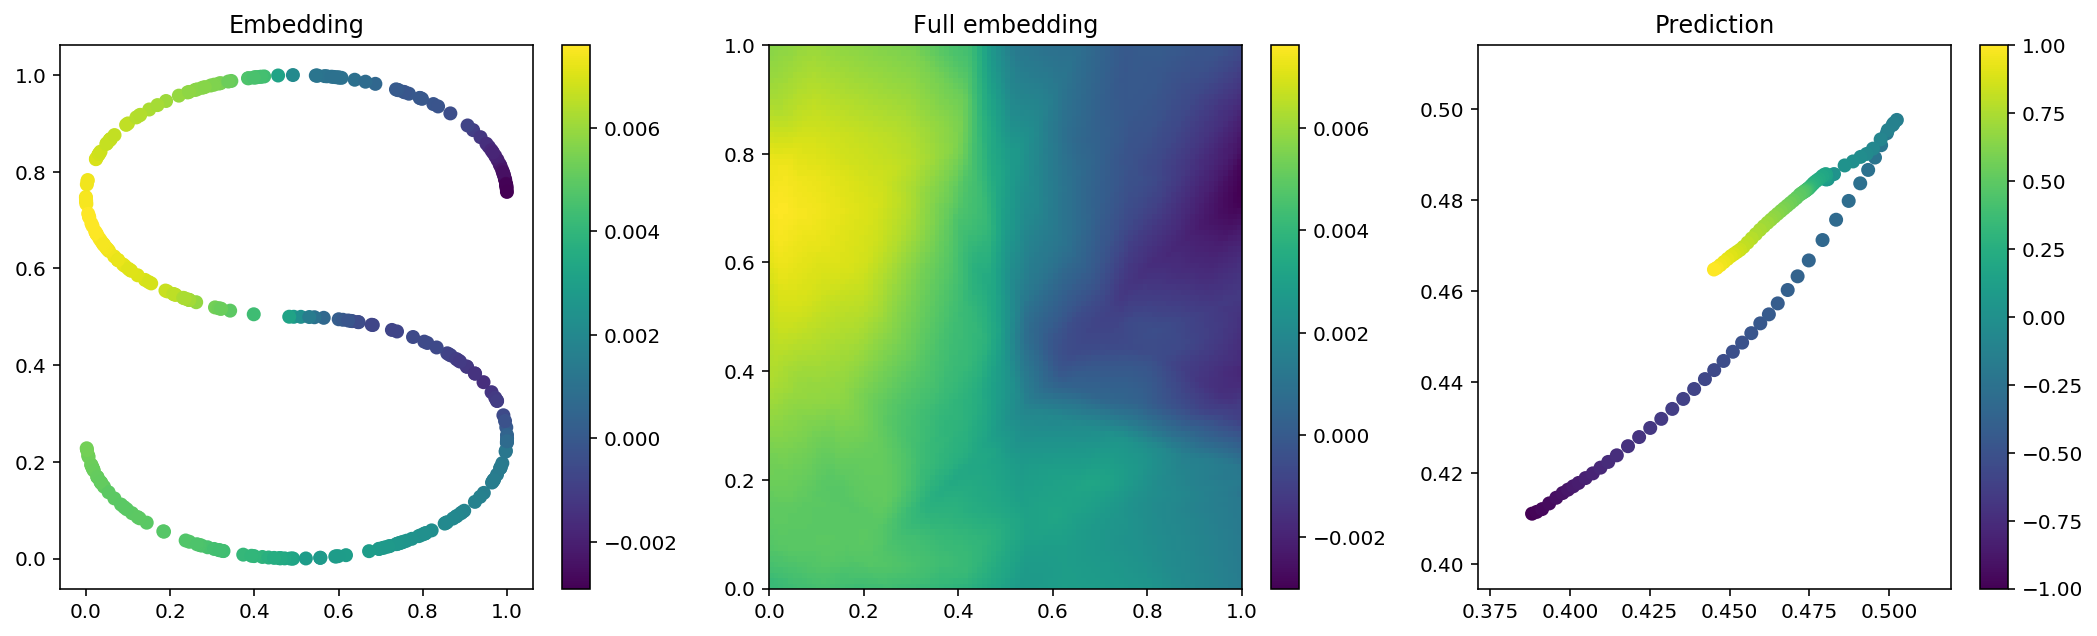

In [34]:
plt.plot(history.epoch, history.history['loss'])

plot_encoder_decoder(encoder, decoder)

Still seems quite terrible. Let's try disabling dropout?

In [35]:
def _plot_in_out(encoder, decoder):
    ''' Plot the input dataset and the corresponding output to which it maps (taking the mean of the latent
        variable distribution).
    '''
    plt.scatter(X[:, 0], X[:, 1], label='Original')
    prediction = decoder.predict(encoder.predict(X))
    plt.scatter(prediction[:, 0], prediction[:, 1], label='After encode/decode')
    plt.legend()
    
def _plot_encode_decode_summary(encoder, decoder, history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.epoch, history.history['loss']);
    plt.subplot(1, 2, 2)
    _plot_in_out(encoder, decoder)

/Users/thomas/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:92: UserWarning: Output "mse_variational_layer_7" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "mse_variational_layer_7" during training.


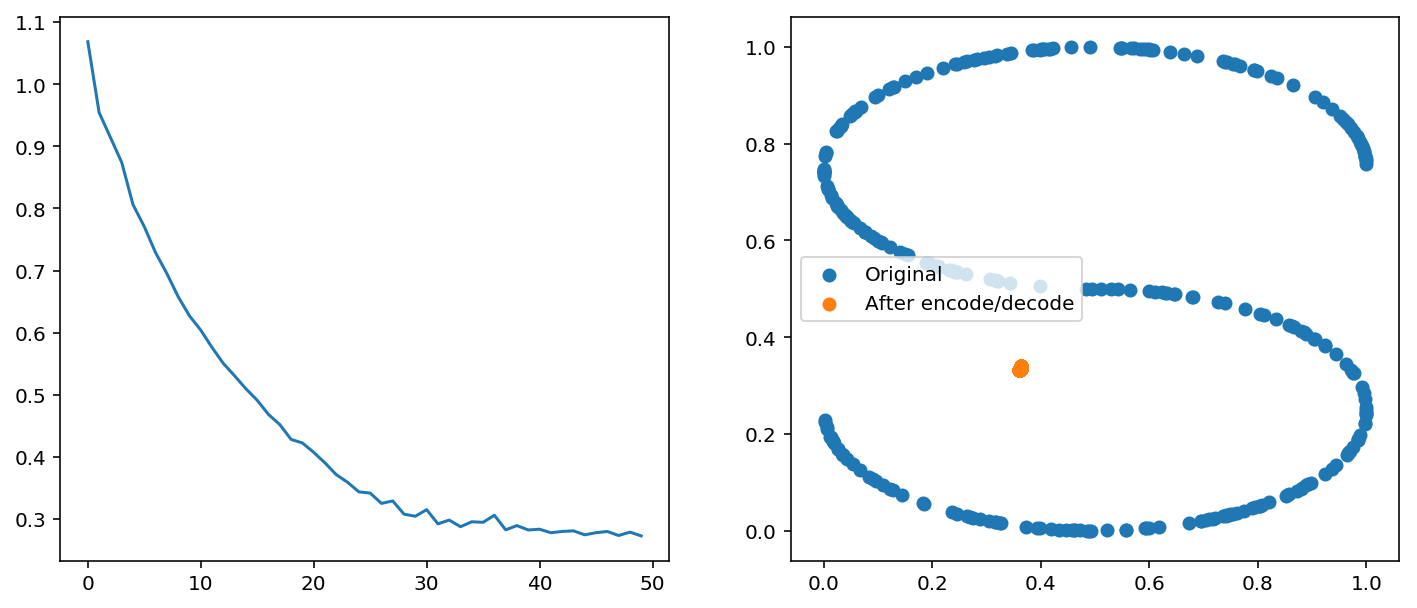

In [36]:
vae, encoder, decoder = make_vae(X.shape[1], dim_latent=1, n_layers=2, dim_intermediate=20, 
                                 cls_vae=MSEVariationalLayer, decoder_activation='tanh',
                                 optimizer=Adam(lr=0.001), dropout=None)
history = _fit_model(vae, epochs=50, verbose=0, batch_size=200)
_plot_encode_decode_summary(encoder, decoder, history)

This isn't working well. Regardless of the parameters we choose, the organey dots are always very tightly clustered. This suggests that the network is having trouble mapping onto all points at the same time... interesting. Does it help at all if we use a higher dimensional latent vector?

/Users/thomas/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:92: UserWarning: Output "mse_variational_layer_8" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "mse_variational_layer_8" during training.


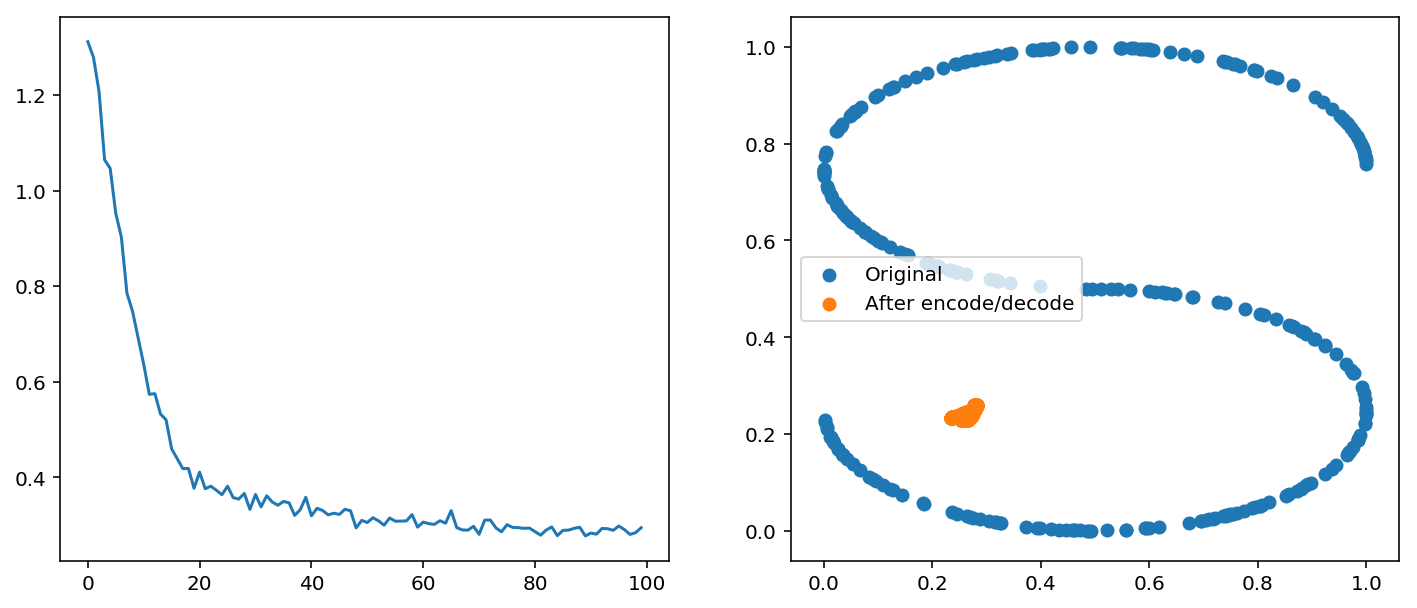

In [37]:
vae, encoder, decoder = make_vae(X.shape[1], dim_latent=10, n_layers=2, dim_intermediate=20, 
                                 cls_vae=MSEVariationalLayer, decoder_activation='tanh',
                                 dropout=None)
history = _fit_model(vae, epochs=100, verbose=0, batch_size=200)
_plot_encode_decode_summary(encoder, decoder, history)

Not really. Perhaps we should remove the decoder activation layer completely?

/Users/thomas/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:92: UserWarning: Output "mse_variational_layer_9" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "mse_variational_layer_9" during training.


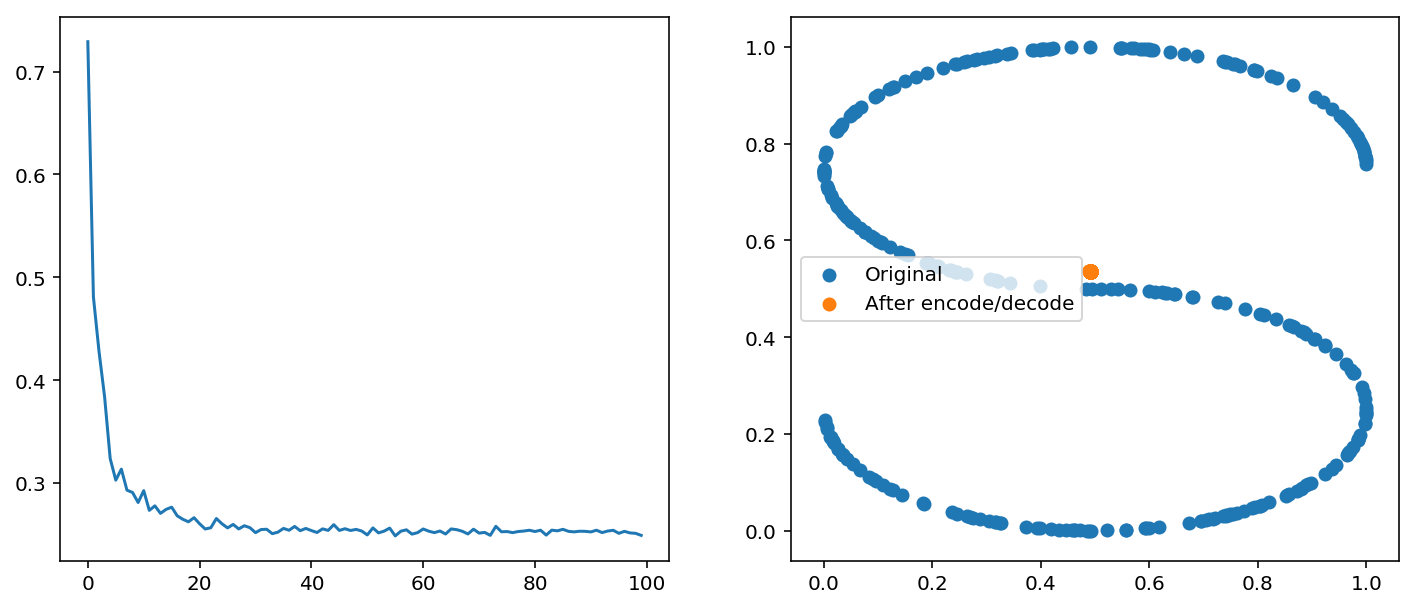

In [38]:
vae, encoder, decoder = make_vae(X.shape[1], dim_latent=2, n_layers=2, dim_intermediate=20, 
                                 cls_vae=MSEVariationalLayer, decoder_activation=None,
                                 dropout=None)
history = _fit_model(vae, epochs=100, verbose=0, batch_size=32)
_plot_encode_decode_summary(encoder, decoder, history)

/Users/thomas/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:92: UserWarning: Output "mse_variational_layer_10" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "mse_variational_layer_10" during training.


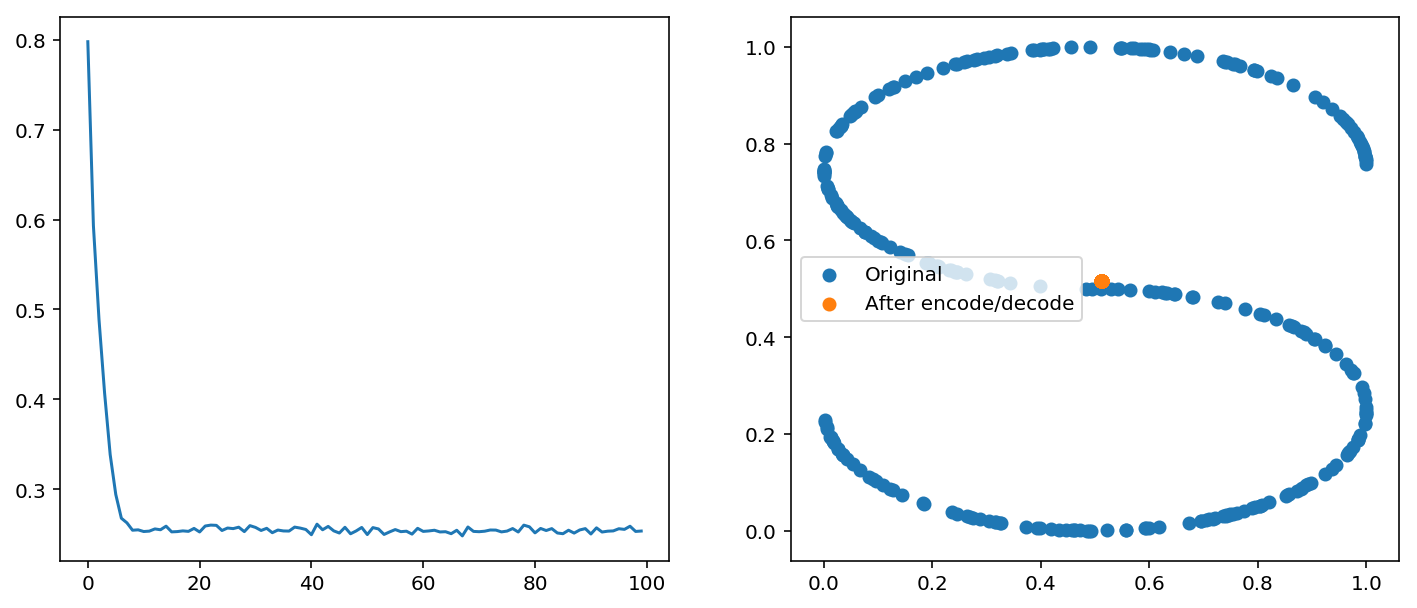

In [39]:
vae, encoder, decoder = make_vae(X.shape[1], dim_latent=2, n_layers=2, dim_intermediate=20, 
                                 cls_vae=MSEVariationalLayer, activation='tanh', decoder_activation=None,
                                 dropout=None)
history = _fit_model(vae, epochs=100, verbose=0, batch_size=32)
_plot_encode_decode_summary(encoder, decoder, history)

### Is there a problem with the KL divergence?
How good a fit can we get if we completely remove the part of the loss term concerned with the KL divergence... this should now be well and truly broken

/Users/thomas/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:92: UserWarning: Output "hacky_variational_layer_4" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "hacky_variational_layer_4" during training.


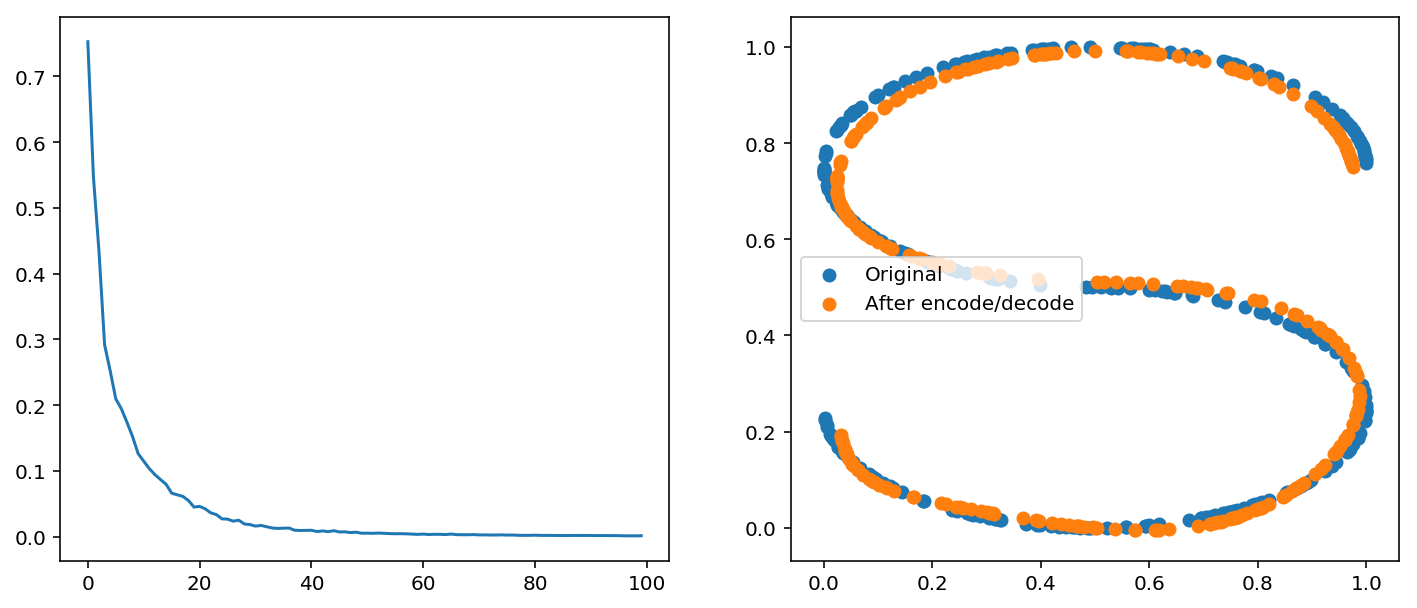

In [40]:
class HackyVariationalLayer(MSEVariationalLayer):
    
    def _vae_loss(self, x, x_decoded_mean, z_mean, z_log_var):
        ''' Hack to disable the KL term '''
        model_loss = self.model_nll(x, x_decoded_mean)
#         kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(model_loss)
    
vae, encoder, decoder = make_vae(X.shape[1], dim_latent=2, n_layers=2, dim_intermediate=20, 
                                 cls_vae=HackyVariationalLayer, activation='tanh', decoder_activation=None,
                                 dropout=None)
history = _fit_model(vae, epochs=100, verbose=0, batch_size=32)
_plot_encode_decode_summary(encoder, decoder, history)

That's interesting -- it's given a two dimensional latent variable, so it ought to be able to do a pretty much exact mapping. What if we just use one dimension?

/Users/thomas/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:92: UserWarning: Output "hacky_variational_layer_5" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "hacky_variational_layer_5" during training.


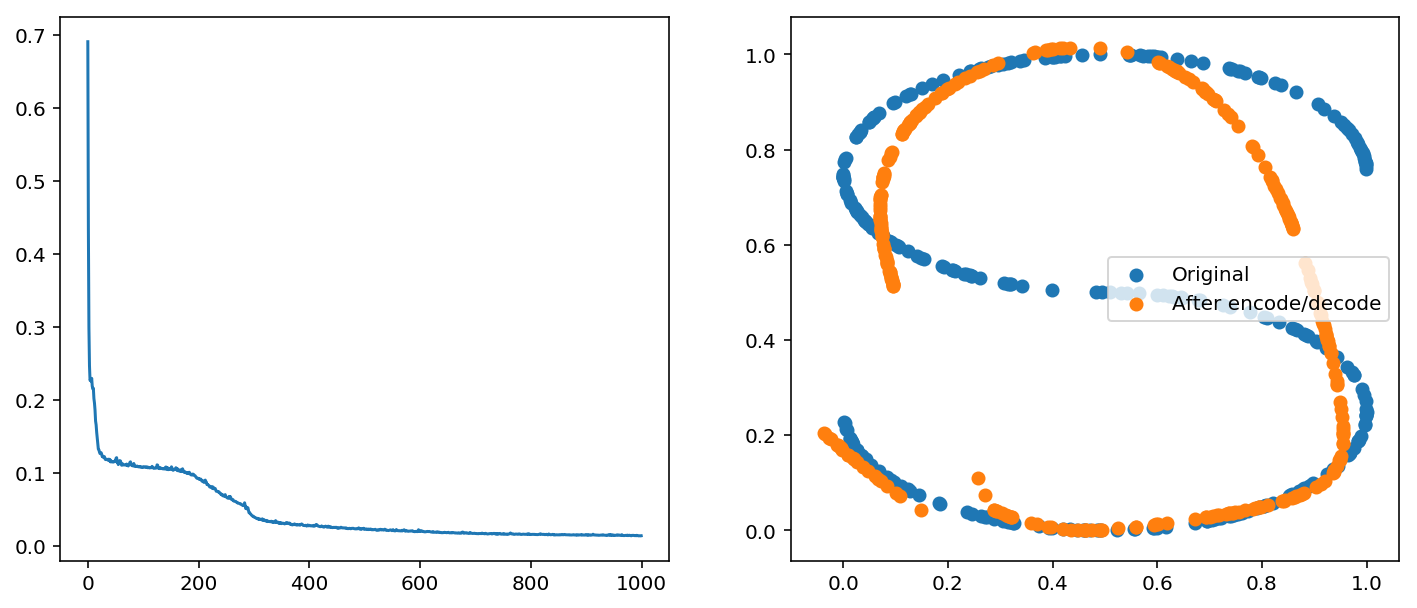

In [41]:
vae, encoder, decoder = make_vae(X.shape[1], dim_latent=1, n_layers=2, dim_intermediate=20, 
                                 cls_vae=HackyVariationalLayer, activation='tanh', decoder_activation=None,
                                 dropout=None)
history = _fit_model(vae, epochs=1000, verbose=0, batch_size=32)
_plot_encode_decode_summary(encoder, decoder, history)

/Users/thomas/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:92: UserWarning: Output "hacky_variational_layer_6" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "hacky_variational_layer_6" during training.


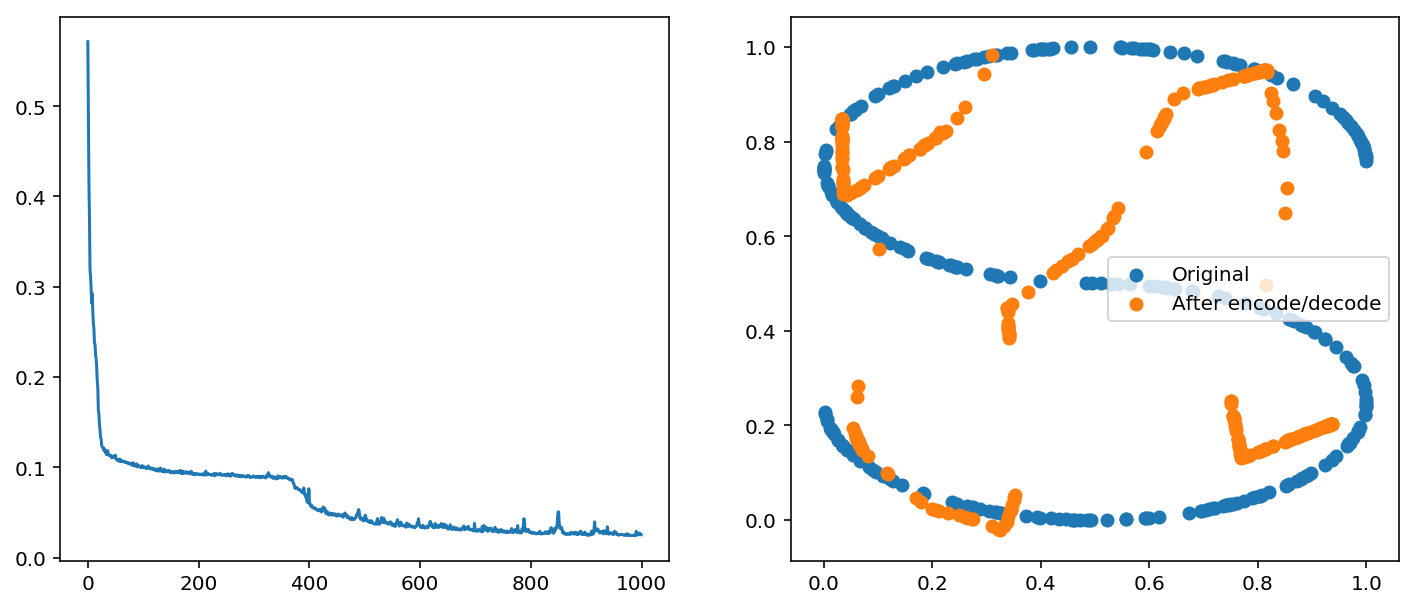

In [42]:
vae, encoder, decoder = make_vae(X.shape[1], dim_latent=1, n_layers=2, dim_intermediate=20, 
                                 cls_vae=HackyVariationalLayer, activation='relu', decoder_activation=None,
                                 dropout=None)
history = _fit_model(vae, epochs=1000, verbose=0, batch_size=32)
_plot_encode_decode_summary(encoder, decoder, history)

Somewhat less than ideal, however it is **significantly** better than we were achieving with a very similar network structure, with the additional variational loss. The way in which we've hobbled the network effectively has made it a straightforward autoencoder. This suggests that either:

1. Our implementation of VAE is wrong
2. There is some parameter / detail that needs tweaking (c.f. switching from multinomial beta dist -> gaussian)
3. There is a "fundamental" reason why trying to fit this kind of problem is hard